<h1> Анализ сайта 
«СберАвтоподписка»

<b>Задачи проекта:</b>

    1. Изучить предоставленный датасет, ответить на вопросы из общей части (подразумевающей базовую обработку данных и их разведочный анализ)

    2. Научится предсказывать совершение целевого действия(ориентировочное значение ROC-AUC ~ 0.65) — факт совершения пользователем целевого действия.

    3. Упаковать получившуюся модель в сервис, который будет брать на вход все атрибуты, типа utm_*, device_*, geo_*, и отдавать на выход 0/1 (1 — если пользователь совершит любое целевое действие).

<b>Описание данных:</b>
    
    Данные из Google Analytics (last-click attribution model) по сайту «СберАвтоподписка».

<b>1. GA Sessions (ga_sessions.pkl)</b>

Одна строка = один визит на сайт.

<b>Описание атрибутов:</b>

    session_id — ID визита;
    client_id — ID посетителя;
    visit_date — дата визита;
    visit_time — время визита;
    visit_number — порядковый номер визита клиента;
    utm_source — канал привлечения;
    utm_medium — тип привлечения;
    utm_campaign — рекламная кампания;
    utm_keyword — ключевое слово;
    device_category — тип устройства;
    device_os — ОС устройства;
    device_brand — марка устройства;
    device_model — модель устройства;
    device_screen_resolution — разрешение экрана;
    device_brand — марка устройства;
    device_model — модель устройства;
    device_screen_resolution — разрешение экрана;
    device_browser — браузер;
    geo_country — страна;
    geo_city — городv

<b>2. GA Hits (ga_hits.pkl)</b>

Одна строка = одно событие в рамках одного визита на сайтv

<b>Описание атрибутов:</b>

    session_id — ID визита;
    hit_date — дата события;
    hit_time — время события;
    hit_number — порядковый номер события в рамках сессии;
    hit_type — тип события;
    hit_referer — источник события;
    hit_page_path — страница события;
    event_category — тип действия;
    event_action — действие;
    event_label — тег действия;
    event_value — значение результата действияv

## 0. Импорт необходимых библиотек

In [2]:
# Импортируем необходимые библиотеки

import dill
import datetime
import math
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pickle
import xgboost as xgb
from matplotlib.ticker import FormatStrFormatter
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

## 1. Загрузка данных

In [4]:
# Загрузка данных сессий и событий

df_sessions = pd.read_csv('dags/modules/data/files/ga_sessions.csv', low_memory=False)
df_hits = pd.read_csv('dags/modules/data/files/ga_hits.csv')

## 2. Data Preparation

### Подготовка датасета

In [7]:
# Подготовка датасета с целевой переменной: приведение целевой переменной в бинарный вид и группировка действий в рамках одной 
# сессии

success = ['sub_car_claim_click', 'sub_car_claim_submit_click', 'sub_open_dialog_click', 'sub_custom_question_submit_click', \
           'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success', 'sub_car_request_submit_click']

index = list(df_hits[df_hits.event_action.isin(success)].index)
df_hits.loc[index, 'event_action_bin'] = 1
df_hits.event_action_bin = df_hits.event_action_bin.fillna(0)

stats_hits = df_hits.groupby(['session_id'], as_index=False)[['event_action_bin']].max()

In [8]:
# Объединение данных на основе session_id

df_full = pd.merge(left=df_sessions, right=stats_hits, on='session_id', how='inner') 

In [9]:
# Приведение типу целевой переменной к целому

df_full['event_action_bin'] = df_full['event_action_bin'].astype(int)
df_full['event_action_bin'].dtype

dtype('int32')

### Анализ данных

In [11]:
# Проверка первых строк объединенных данных

df_full.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,event_action_bin
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0


In [12]:
# Проверка размерности данных

df_full.shape

(1732266, 19)

In [13]:
# Вывод уникальных значений для колонки event_action_bin (таргета)

df_full.event_action_bin.value_counts()

event_action_bin
0    1681952
1      50314
Name: count, dtype: int64

In [14]:
# Проверка датасета на отсутствие дублирующих записей

df_full = df_full.drop_duplicates()
print('Количество дублирующихся записей - ', len(df_full[df_full.duplicated()].values)) 

Количество дублирующихся записей -  0


In [15]:
# Проверка датасета на пропущенные значения и типы столбцов

df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732266 entries, 0 to 1732265
Data columns (total 19 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
 18  event_action_bin          int32 
dtypes: int32(1), int64(1), object(17)
memory usage: 244.5+ MB


In [16]:
# Вывод количества уникальных значений для каждого столбца

df_full.nunique()

session_id                  1732266
client_id                   1320704
visit_date                      226
visit_time                    85032
visit_number                    533
utm_source                      280
utm_medium                       55
utm_campaign                    406
utm_adcontent                   280
utm_keyword                    1192
device_category                   3
device_os                        13
device_brand                    200
device_model                    104
device_screen_resolution       4947
device_browser                   55
geo_country                     159
geo_city                       2389
event_action_bin                  2
dtype: int64

In [17]:
# Вывод описательных статистик для числовых фичей

df_full.describe()

,visit_number,event_action_bin
count,1.732266e+06,1.732266e+06
mean,2.627835e+00,2.904519e-02
std,1.164260e+01,1.679333e-01
min,1.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00
50%,1.000000e+00,0.000000e+00
75%,1.000000e+00,0.000000e+00
max,5.640000e+02,1.000000e+00


<b>Оценка качества данных

<b>Общая информация о датасете:

    - Датасет содержит 19 колонок и 1732266 строк.
    - Всего 2 числовых столбца (visit_number, event_action_bin), остальные данные имеют тип object, что включает в себя строки.
    - Объем памяти, занимаемый датасетом, составляет более 244.5+ MB.
<b>Пропущенные значения:

    - Большинство столбцов имеют пропущенные значения, что требует внимания при предобработке данных.

### Ислледуем данные на пропуски, обрабатываем их

In [31]:
# Определение количества полностью заполненных объектов, процент и количество пропущенных значений в признаках:

def print_useful_rows_info(df):
    print('Количество полностью заполненных объектов из всей выборки:', len(df.dropna()))
    print('Процент полностью заполненных объектов из всей выборки:', round(len(df.dropna()) / len(df) * 100, 2))
print_useful_rows_info(df_full)
missing_values = ((df_full.isna().sum() / len(df_full)) * 100).sort_values(ascending=False)
print(f'Процент пропущенных значений:\n' + f'{missing_values}')

Количество полностью заполненных объектов из всей выборки: 13829
Процент полностью заполненных объектов из всей выборки: 0.8
Процент пропущенных значений:
device_model                99.130503
utm_keyword                 58.925823
device_os                   58.533966
device_brand                20.042880
utm_adcontent               17.557177
utm_campaign                11.273500
utm_source                   0.004387
geo_city                     0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
session_id                   0.000000
device_category              0.000000
client_id                    0.000000
utm_medium                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
event_action_bin             0.000000
dtype: float64


In [32]:
# Определение количества пропущенных значений в столбцах:

def missing_values(df):
    missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending=False)
    for i in range(0, len(missing_values)):
        if missing_values.iloc[i] > 0:
            print(missing_values.index[i], '-', df.loc[:, missing_values.index[i]].isna().sum())

print('Количество пропущенных значений в столбцах:')
missing_values(df_full)

Количество пропущенных значений в столбцах:
device_model - 1717204
utm_keyword - 1020752
device_os - 1013964
device_brand - 347196
utm_adcontent - 304137
utm_campaign - 195287
utm_source - 76


In [33]:
# Удаление столбцов с 99% пропусков

df_full = df_full.drop(columns=['device_model'])

In [34]:
# Замена пропусков в марке устройства и отсутствующих данных

df_full.loc[df_full['device_os'] == 'Macintosh', 'device_brand'] = 'Apple'
df_full.device_brand = df_full.device_brand.fillna('unknown')

for column in df_full.columns:
    df_full.loc[:, column] = df_full.loc[:, column].apply(lambda x: 'unknown' if x == '(not set)' else x)

In [35]:
# Восстановление отсутствующих записей об операционной системе устройства

def os_recovery(df):
    stats = df.groupby([df.columns[0], df.columns[1]], as_index=False)[df.columns[2]].agg(pd.Series.mode)
    for i in range(0, len(stats)):
        try:
            index_list = list(df[(df[df.columns[2]].isna()) & (df[df.columns[0]] == stats.loc[i, df.columns[0]]) & \
            (df[df.columns[1]] == stats.loc[i, df.columns[1]])].index)
            df.loc[index_list, df.columns[2]] = stats.loc[i, df.columns[2]]
        except:
            pass
    df[df.columns[2]][df[df.columns[2]].isna()] = 'unknown'
    return df[df.columns[2]]

df_full.device_os = os_recovery(df_full.loc[:, ['device_brand', 'device_category', 'device_os']])

In [36]:
# Удаление строк датафрейма с 3-мя и более отсутствующими UTM-метками, а также отсутствующими значениями utm_source

utm_nan = list(df_full[(df_full.utm_keyword.isna()) & (df_full.utm_campaign.isna()) & (df_full.utm_adcontent.isna())].index) + \
list(df_full[df_full.utm_source.isna()].index)
df_full = df_full.drop(axis=0, index=utm_nan)

In [ ]:
# Разбиение признаков utm-меток на группы и заполнение пропусков признаков utm-меток модой для соответствующей группы

def utm_recovery(df):
    stats = df.groupby([df.columns[0], df.columns[1], df.columns[2]], as_index=False)[df.columns[3]].agg(pd.Series.mode)
    for i in range(0, len(stats)):
        try:
            index_list = list(df[(df[df.columns[3]].isna()) & (df[df.columns[0]] == stats.loc[i, df.columns[0]]) & \
            (df[df.columns[1]] == stats.loc[i, df.columns[1]]) & (df[df.columns[2]] == stats.loc[i, df.columns[2]])].index)
            df.loc[index_list, df.columns[3]] = stats.loc[i, df.columns[3]]
        except:
            pass
    df[df.columns[3]][df[df.columns[3]].isna()] = 'unknown'
    return df[df.columns[3]]

df_full.utm_campaign = utm_recovery(df_full.loc[:, ['utm_source', 'utm_medium', 'utm_adcontent', 'utm_campaign']])
df_full.utm_adcontent = utm_recovery(df_full.loc[:, ['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent']])
df_full.utm_keyword = utm_recovery(df_full.loc[:, ['utm_adcontent', 'utm_medium', 'utm_campaign', 'utm_keyword']])

In [ ]:
# Вывод количества пропусков в оставшихся признаках

print_useful_rows_info(df_full)
print('Количество пропущенных значений в столбцах:')
missing_values(df_full)

### Обработка других колонок

In [ ]:
# Проверка на наличие близких значений в столбце device_browser

df_full.device_browser.unique()

In [ ]:
# Обработка и объединение подобных или аналогичных браузеров, замена невалидных значений

df_full['device_browser'] = df_full['device_browser'].apply(lambda x: x.split(' ')[0].lower()).replace({'helloworld':'other', \
'[fban':'other', 'mrchrome':'chrome', 'MyApp':'other', 'nokiax2-02':'other', 'nokia501':'other', 'com.zhiliaoapp.musically':\
                                                                                                'other', 'threads':'other'})
df_full.device_browser.unique()

### Data Visualization

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(df_full['event_action_bin'].unique(), df_full['event_action_bin'].value_counts(), width=0.5, color=['tomato', 'lightskyblue'])
ax.set_xlabel('Значение целевой переменной')
ax.set_ylabel('Частота')
ax.set_title('Распределение значений целевой переменной')
ax.tick_params(axis='both', labelsize=12)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) 

ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'));

In [ ]:
# Построение диаграммы заполненности столбцов (после обработки)

msno.bar(df_full)

In [ ]:
#Построение матрицы заполненности столбцов (после обработки)

msno.matrix(df_full)

In [ ]:
# Вывод статистик по посещаемости сайта

stat_session_id = df_full.groupby(['visit_date'], as_index=False)[['session_id']].count()
stat_session_id = stat_session_id.rename(columns={'session_id': 'session_count'}).sort_values(by='visit_date', ascending=True)
stat_session_id.head(3)

In [ ]:
# Вывод статистик о совершении целевого действия

stat_event_action = df_full.groupby(['visit_date'], as_index=False)[['event_action_bin']].sum()
stat_event_action = stat_event_action.rename(columns={'event_action_bin': 'count_success_event_action'}).sort_values(by='visit_date', ascending=True)
stat_event_action.head(3)

In [40]:
# Вывод статистик конверсии посещения сайта в целевое действие

stat_event_conversion = df_full.groupby(['visit_date'], as_index=False).agg({'event_action_bin': 'mean'})
stat_event_conversion = stat_event_conversion.rename(columns={'event_action_bin': 'conversion'})
stat_event_conversion.head(3)

,visit_date,conversion
0,2021-05-19,0.071124
1,2021-05-21,0.000000
2,2021-05-22,0.014306


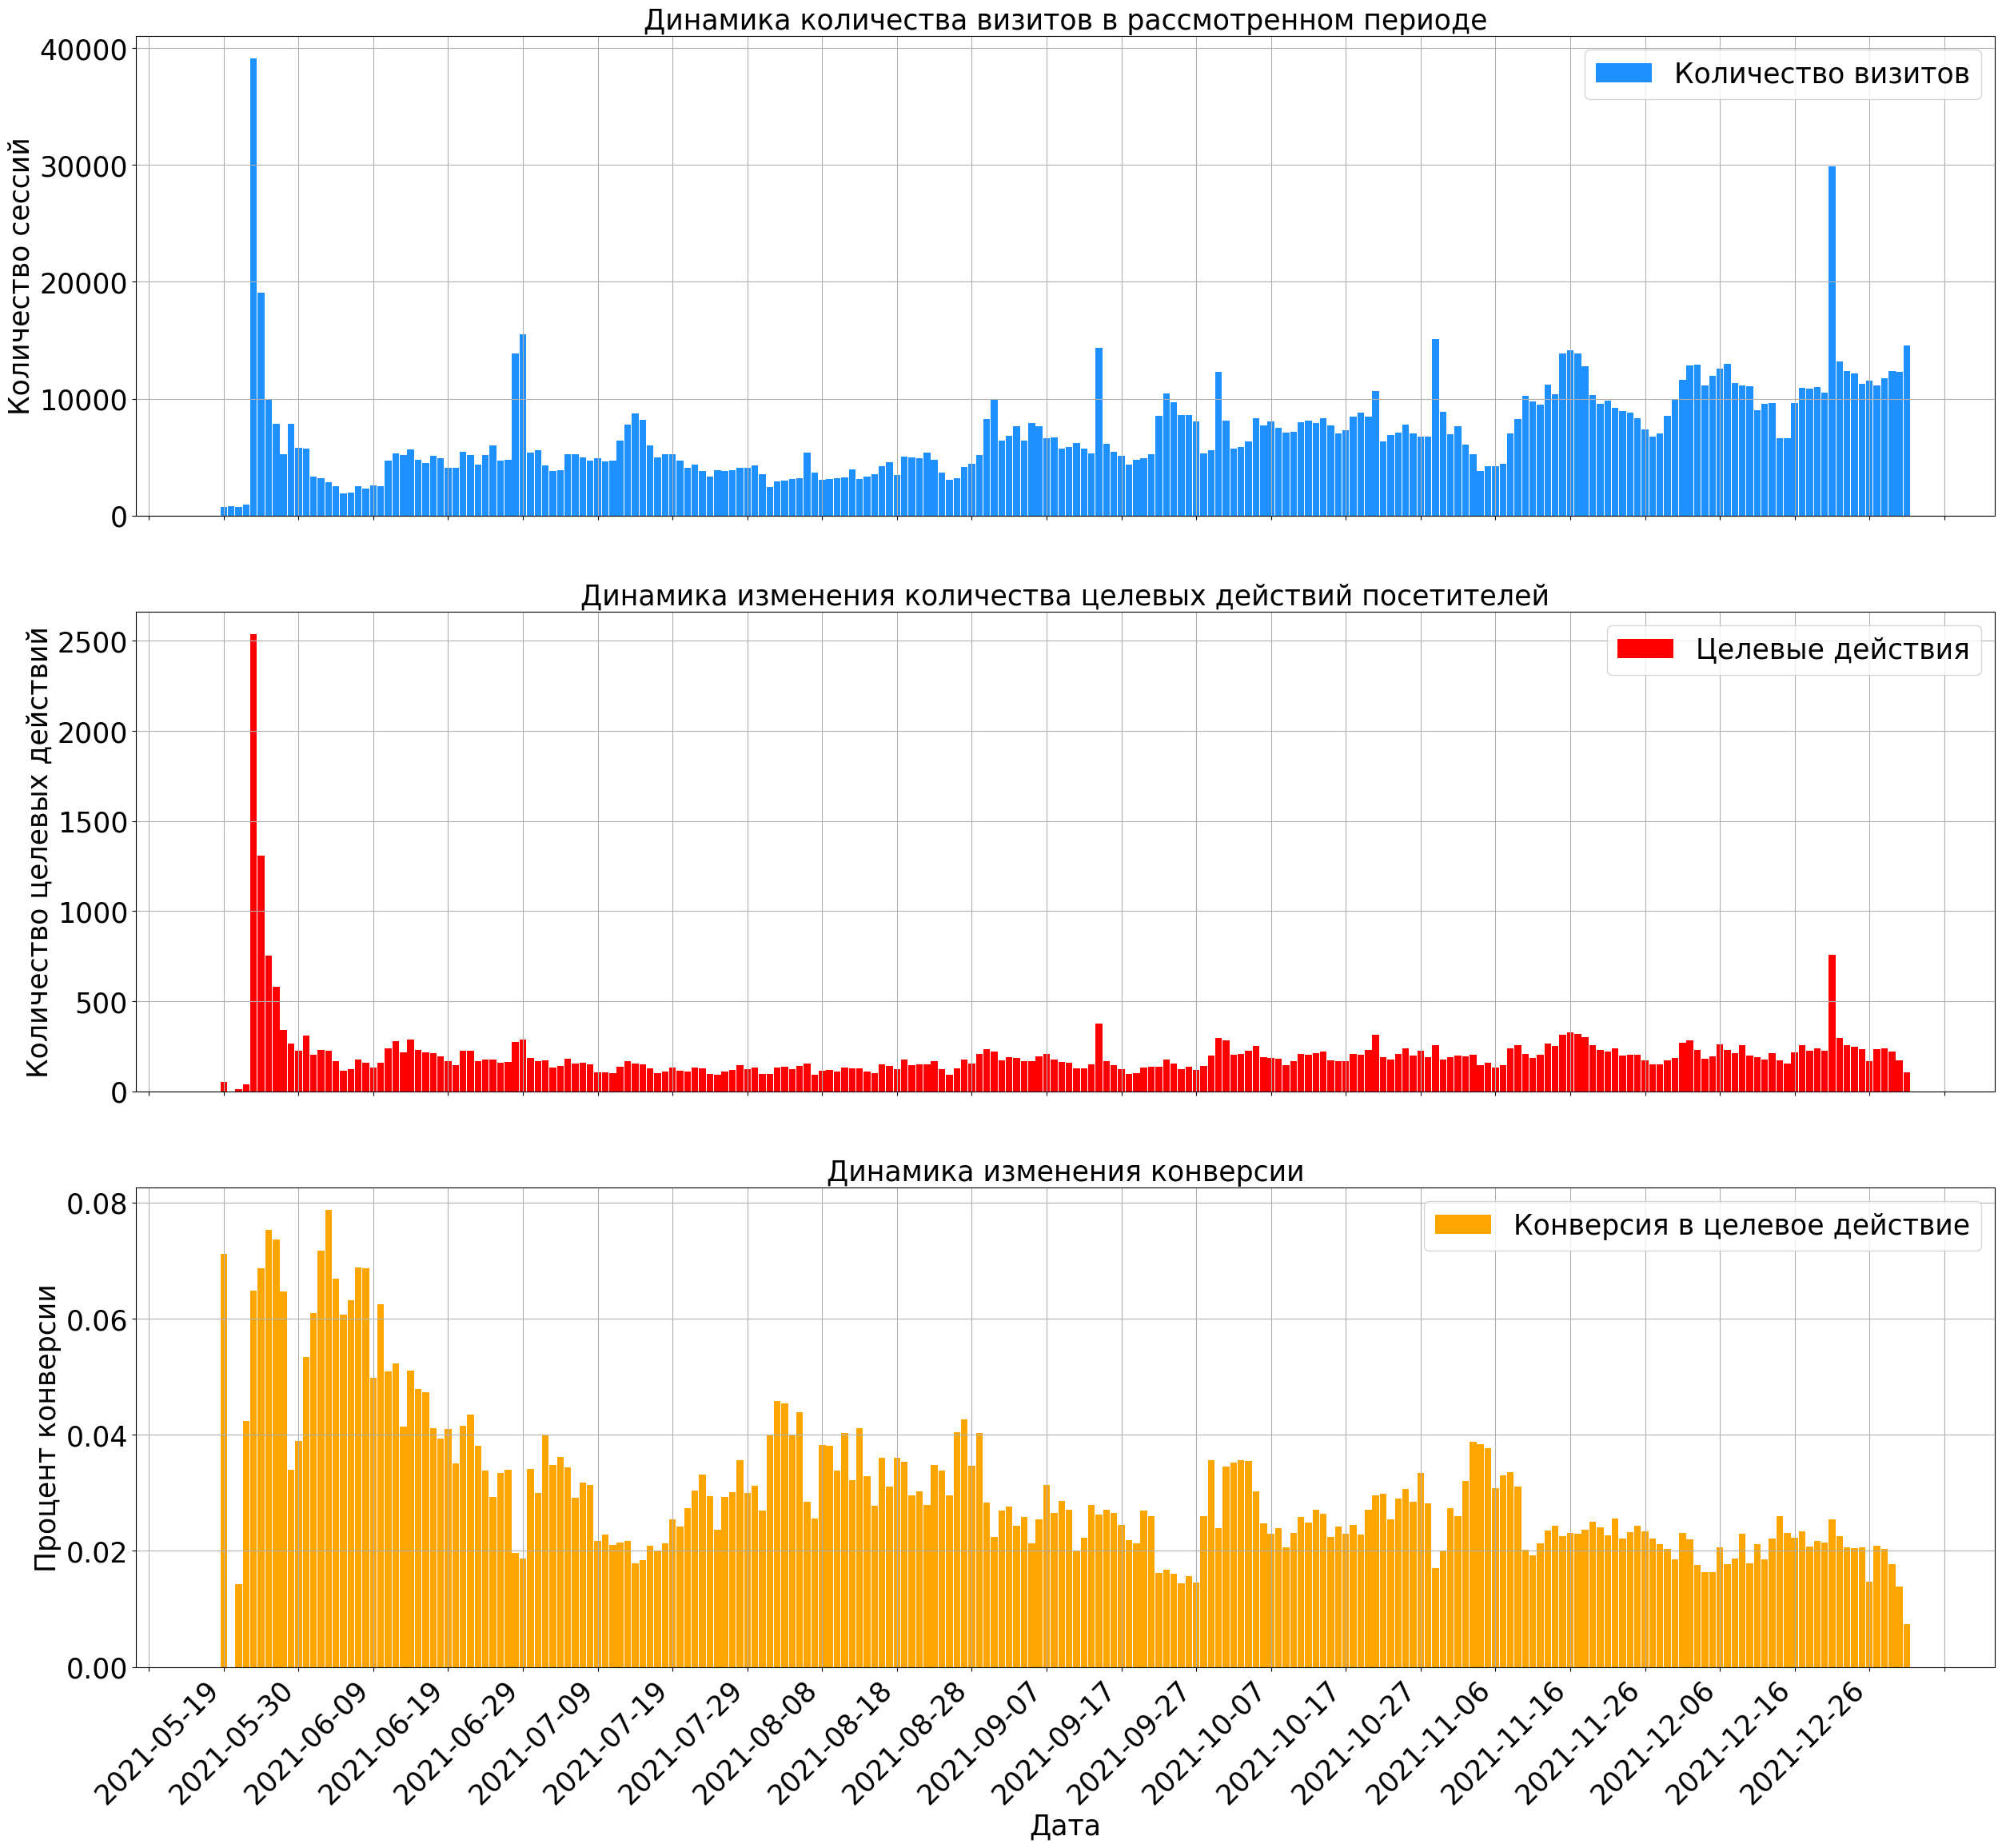

In [41]:
# Графики динамики визитов, совершения целевых действий и конверсии


fig, ax = plt.subplots(3, 1, figsize=(30, 30))
ax[0].bar(stat_session_id['visit_date'], stat_session_id['session_count'], width=0.9, color='dodgerblue', \
                                                                            label='Количество визитов')
ax[1].bar(stat_event_action['visit_date'], stat_event_action['count_success_event_action'], width=0.9, color='red', \
                                                                            label='Целевые действия')
ax[2].bar(stat_event_conversion['visit_date'], stat_event_conversion['conversion'], width=0.9, color='orange', \
                                                                            label='Конверсия в целевое действие')

ax[0].legend(loc='upper right', fontsize = 25)
ax[1].legend(loc='upper right', fontsize = 25)
ax[2].legend(loc='upper right', fontsize = 25)

ax[0].set_title('Динамика количества визитов в рассмотренном периоде', fontsize = 25)
ax[1].set_title('Динамика изменения количества целевых действий посетителей', fontsize = 25)
ax[2].set_title('Динамика изменения конверсии', fontsize = 25)

ax[0].set_xlabel('Дата')
ax[1].set_xlabel('Дата')
ax[2].set_xlabel('Дата', fontsize = 25)

ax[0].set_ylabel('Количество сессий', fontsize = 25)
ax[1].set_ylabel('Количество целевых действий', fontsize = 25)
ax[2].set_ylabel('Процент конверсии', fontsize = 25)

ax[0].tick_params(axis='both', labelsize=25)
ax[1].tick_params(axis='both', labelsize=25)
ax[2].tick_params(axis='both', labelsize=25)

ax[0].xaxis.set_major_locator(ticker.MultipleLocator(10))    
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(10)) 
ax[2].xaxis.set_major_locator(ticker.MultipleLocator(10)) 

ax[0].grid()
ax[1].grid()
ax[2].grid()

fig.autofmt_xdate(rotation=45);

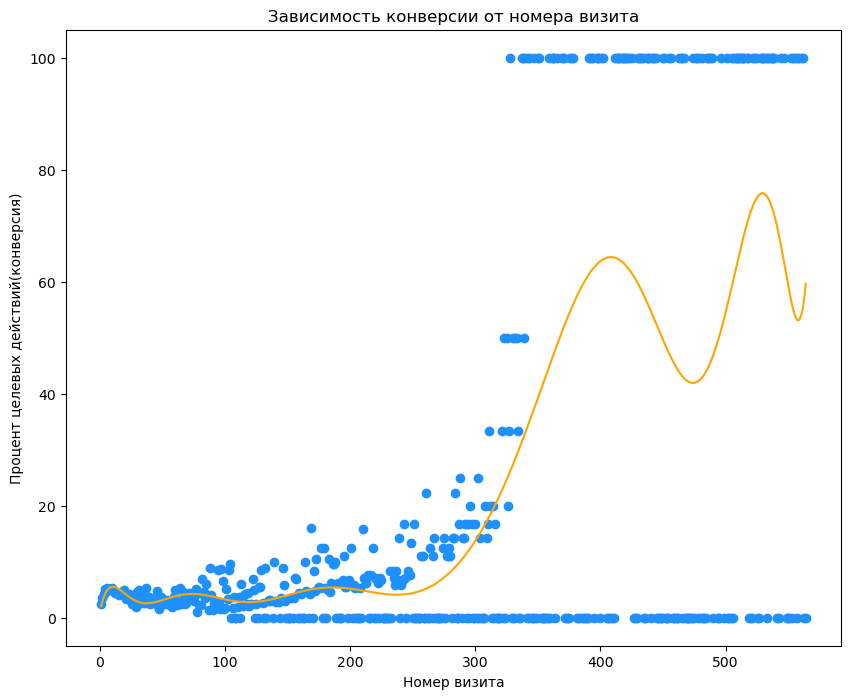

In [42]:
# Вывод зависимости конверсии в целевое действие от порядкового номера визита

stats1 = df_full.groupby(['event_action_bin', 'visit_number'], as_index=False)[['session_id']].count()
stats1 = stats1.rename(columns={'session_id': 'count'}).sort_values(by='visit_number', ascending=True)
p_set = set()
for elem in stats1['visit_number']:
    p_set.add(elem)
    
chart_coords1 = []

for i in p_set:
    
    chart_coords1.append((i, (sum(stats1.event_action_bin[stats1['visit_number'] == i] * \
                                 stats1['count'][stats1['visit_number'] == i])) / stats1['count'][stats1['visit_number'] == i].sum() * 100))
d1 = pd.DataFrame(chart_coords1, columns=['x', 'y'])
plt.figure(figsize=(10, 8))
plt.scatter(d1['x'], d1['y'], color='dodgerblue')

z = np.polyfit (d1['x'], d1['y'], 13)
p = np.poly1d (z)
plt.plot(d1['x'], p(d1['x']), color='orange')

plt.xlabel('Номер визита')
plt.ylabel('Процент целевых действий(конверсия)')
plt.title('Зависимость конверсии от номера визита');

In [43]:
# Создание функции для рассчета статистик признаков

def feature_stats(df, feature):
    stats = df.groupby([feature], as_index=False)[['session_id']].count()
    stats = stats.rename(columns={'session_id': 'count'}).sort_values(by='count', ascending=False)
    return stats

In [44]:
# Создание функции для построения графика распределения

def distribution_graph(stats, feature, figsize, feature_sence, n_first_fiatures):
    if n_first_fiatures != 'all':
        stats = stats.head(n_first_fiatures)
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(stats[feature], stats['count'], width=0.9, color=['orange', 'dodgerblue'])
    ax.set_xlabel('Название ' + feature_sence, fontsize = 20)
    ax.set_ylabel('Частота', fontsize = 20)
    ax.set_title('Распределение ' + feature_sence, fontsize = 20)
    ax.tick_params(axis='both', labelsize=14)
    fig.autofmt_xdate(rotation=45);
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'));

In [45]:
# Статистики для столбца, содержащего значения utm-метки с доп.информацией

stats_adcontent = feature_stats(df_full, 'utm_adcontent')
stats_adcontent.head(5)

,utm_adcontent,count
45,JNHcPlZPxEMWDnRiyoBf,1007117
245,vCIpmpaGBnIQhyYNkXqp,179438
240,unknown,106001
264,xhoenQgDQsgfEPYNPwKO,104381
82,PkybGvWbaqORmxjNunqZ,59038


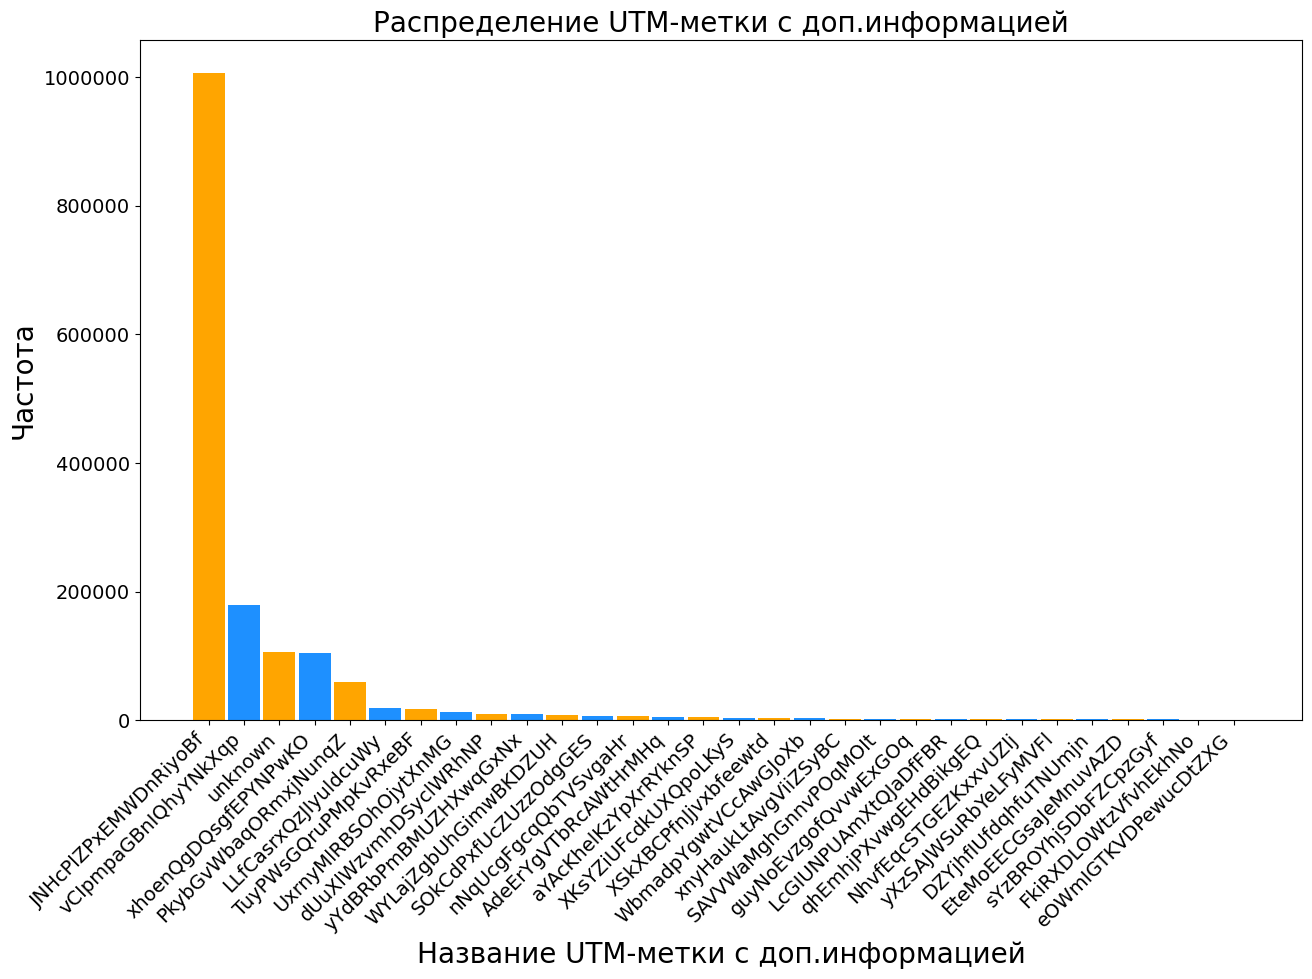

In [46]:
# График распределения для utm-меткок с доп.информацией (30 наиболее часто встречающихся)

distribution_graph(stats_adcontent, 'utm_adcontent', (15, 10), 'UTM-метки с доп.информацией', 30)

In [47]:
# Статистики для столбца, содержащего значения utm-метки с названием компании

stats_campaign = feature_stats(df_full, 'utm_campaign')
stats_campaign.head(5)

,utm_campaign,count
87,LTuZkdKfxRGVceoWkVyg,423139
84,LEoPHuyFvzoNfnzGgfcd,321286
39,FTjNLDyTrXaWYgZymFkV,234950
255,gecBYcKZCPMcVYdSSzKP,133247
358,unknown,60749


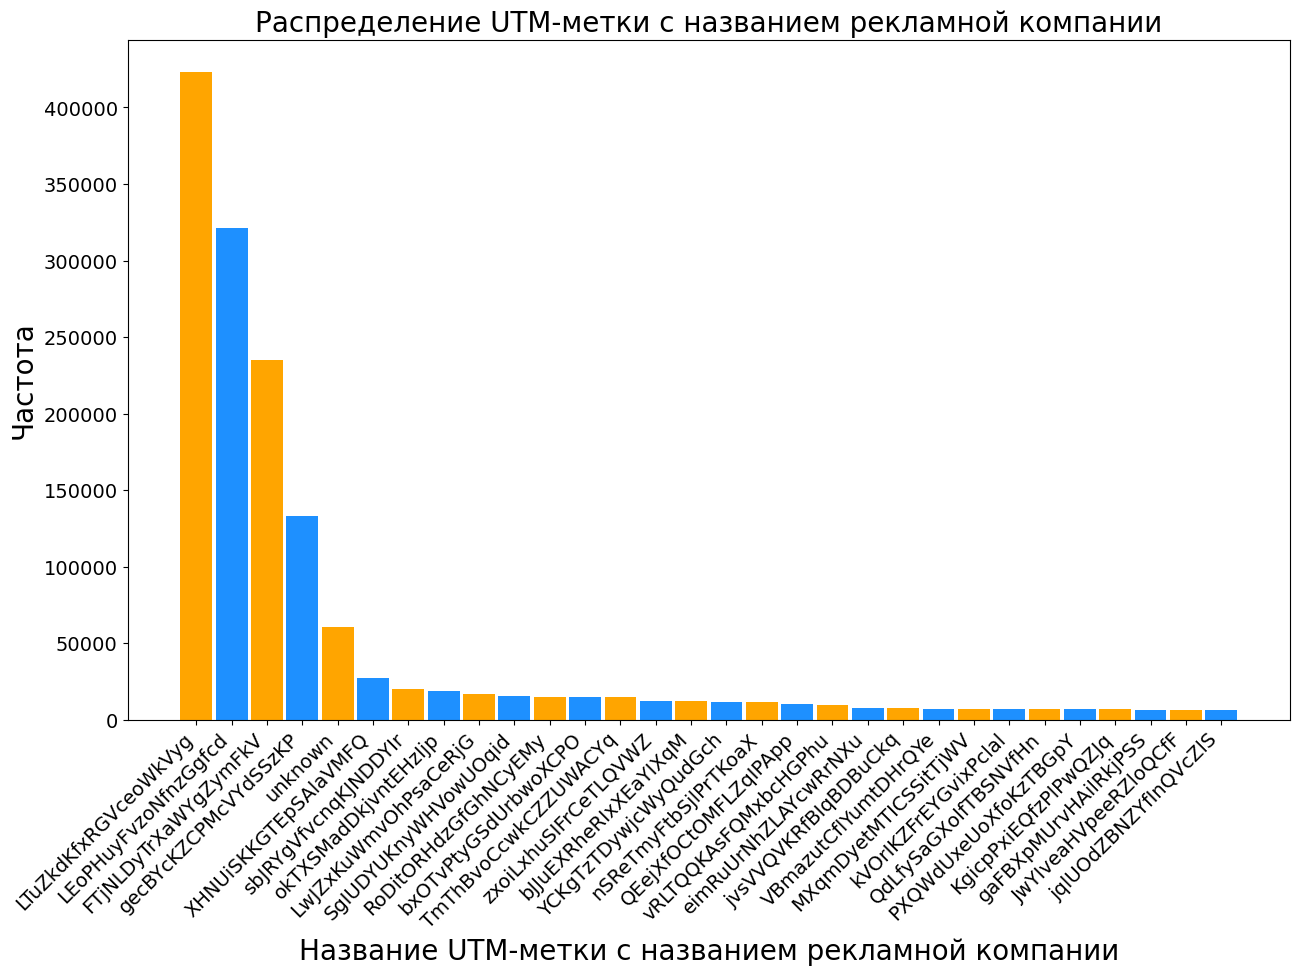

In [48]:
# График распределения для utm-меткок с доп.информацией (30 наиболее часто встречающихся)

distribution_graph(stats_campaign, 'utm_campaign', (15, 10), 'UTM-метки с названием рекламной компании', 30)

In [49]:
# Статистики для столбца, содержащего значения utm-метки о источнике трафика

stats_source = feature_stats(df_full, 'utm_source')
stats_source.head(5)

,utm_source,count
148,ZpYIoDJMcFzVoPFsHGJL,552555
175,fDLlAcSmythWSCVMvqvL,277060
209,kjsLglQLzykiRbcDiGcD,202790
77,MvfHsxITijuriZxsqZqt,175831
155,bByPQxmDaMXgpHeypKSM,85671


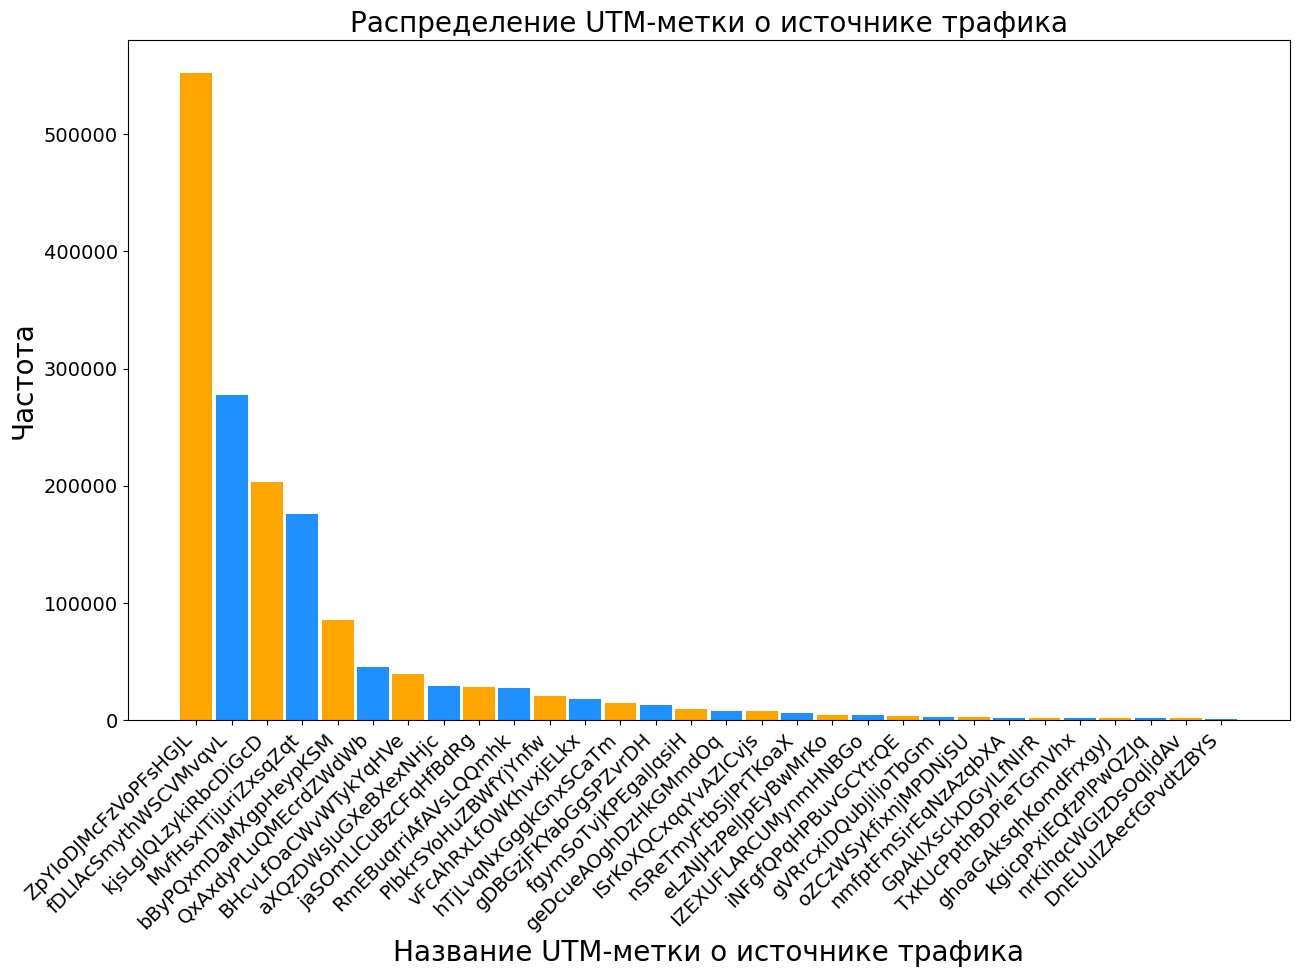

In [50]:
# График распределения для utm-меткок о источнике трафика(30 наиболее часто встречающихся)

distribution_graph(stats_source, 'utm_source', (15, 10), 'UTM-метки о источнике трафика', 30)

In [51]:
# Статистики для столбца, содержащего значения utm-метки о типе канала

stats_medium = feature_stats(df_full, 'utm_medium')
stats_medium.head(5)

,utm_medium,count
3,banner,525206
11,cpc,283165
0,(none),277060
12,cpm,229791
37,referral,132166


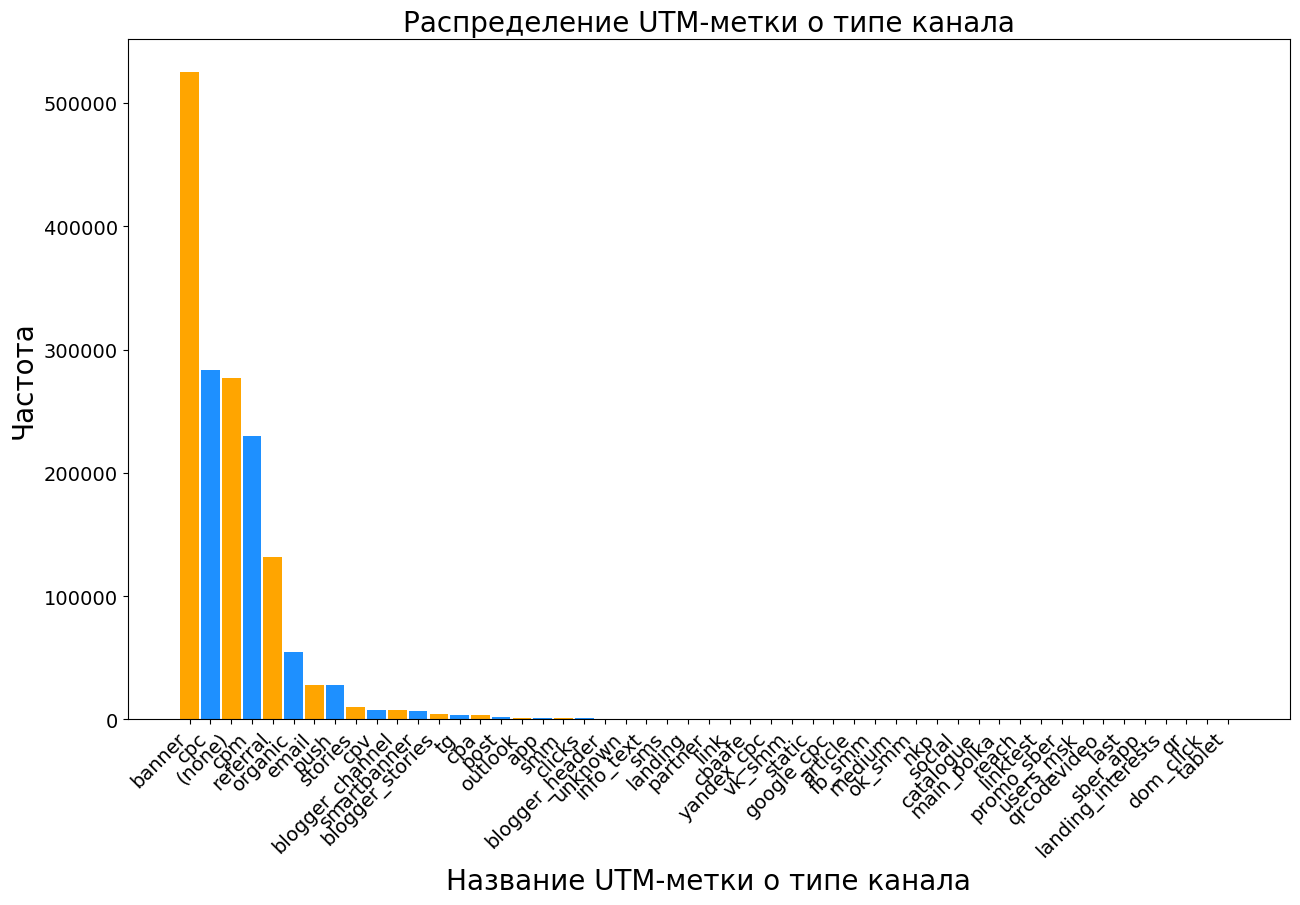

In [52]:
# График распределения для utm-меткок о типе канала

distribution_graph(stats_medium, 'utm_medium', (15, 10), 'UTM-метки о типе канала', 'all')

In [53]:
# Статистики для столбца, содержащего значения utm-метки с ключевым словом

stats_keyword = feature_stats(df_full, 'utm_keyword')
stats_keyword.head(5)

,utm_keyword,count
957,puhZPIYqKXeFPaUviSjo,1060801
1058,unknown,52903
313,NUYvxgBEIYqMlnpeDTIM,49442
747,hAmNSZmQkKQKAjZEGlgb,39987
456,UKNBOHebRIIsQRsjNKay,37854


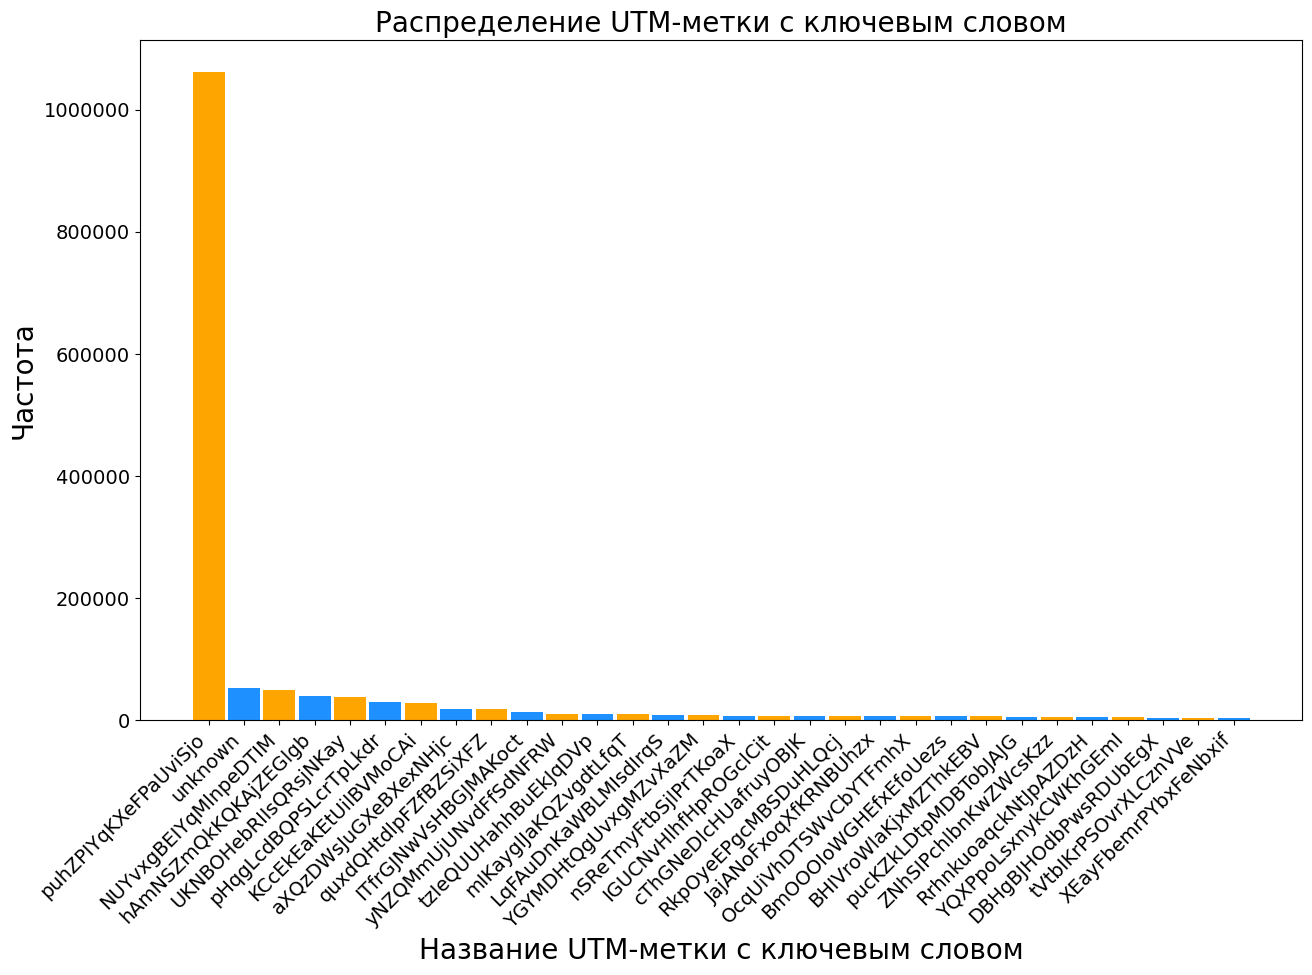

In [54]:
# График распределения для utm-меткок с ключевым словом(30 наиболее часто встречающихся)

distribution_graph(stats_keyword, 'utm_keyword', (15, 10), 'UTM-метки с ключевым словом', 30)

In [55]:
# Статистики для столбца с информацией об операционной системе устройства

stats_os = feature_stats(df_full, 'device_os')
stats_os

,device_os,count
0,Android,842404
11,iOS,459801
9,Windows,280540
5,Macintosh,23414
4,Linux,4616
12,unknown,395
2,Chrome OS,65
1,BlackBerry,24
8,Tizen,7
3,Firefox OS,3


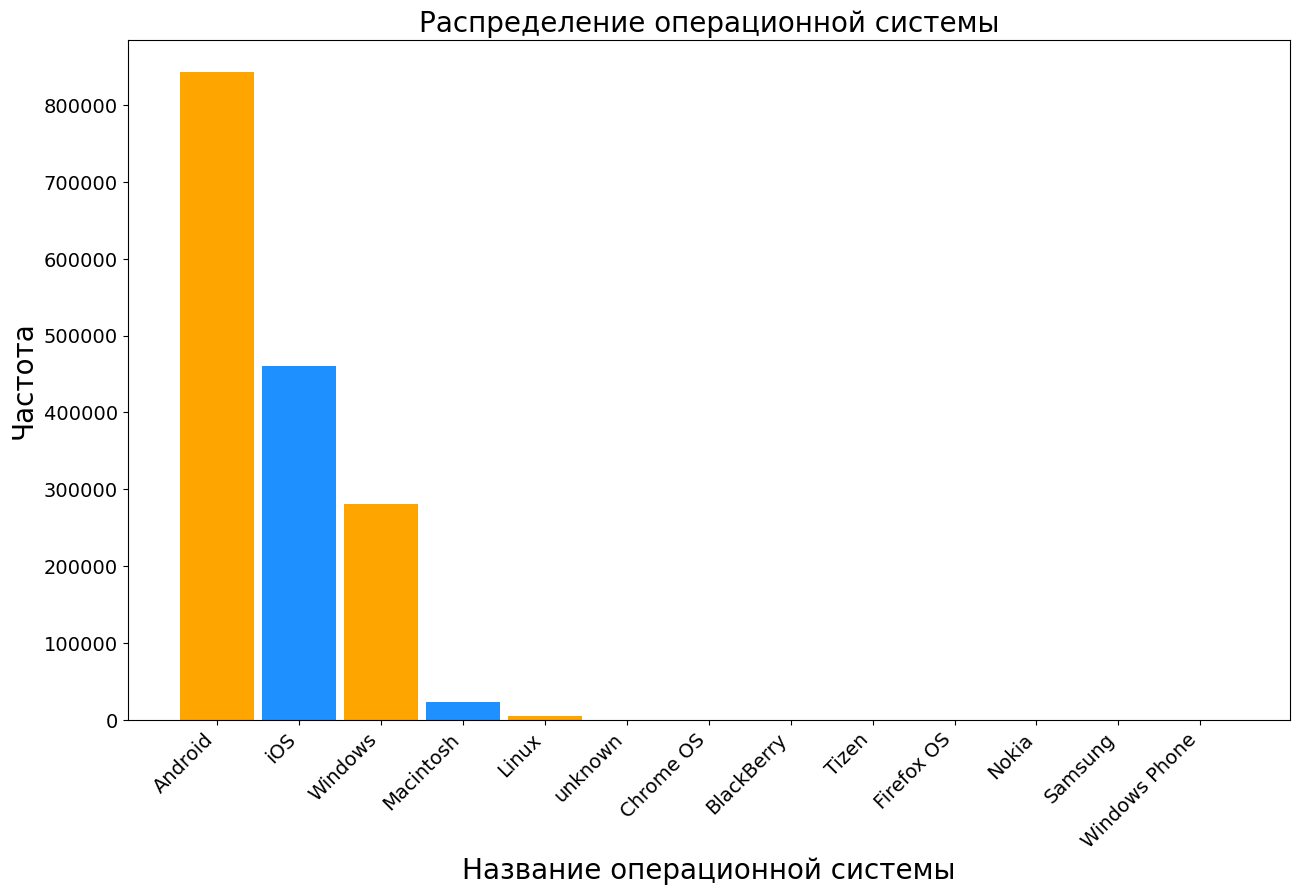

In [56]:
# График распределения для столбца с информацией об операционной системе устройства

distribution_graph(stats_os, 'device_os', (15, 10), 'операционной системы', 'all')

In [57]:
# Статистики для столбца с информацией о марке устройства

stats_brand = feature_stats(df_full, 'device_brand')
stats_brand.head(5)

,device_brand,count
9,Apple,483210
197,unknown,301508
142,Samsung,296983
188,Xiaomi,257952
75,Huawei,165981


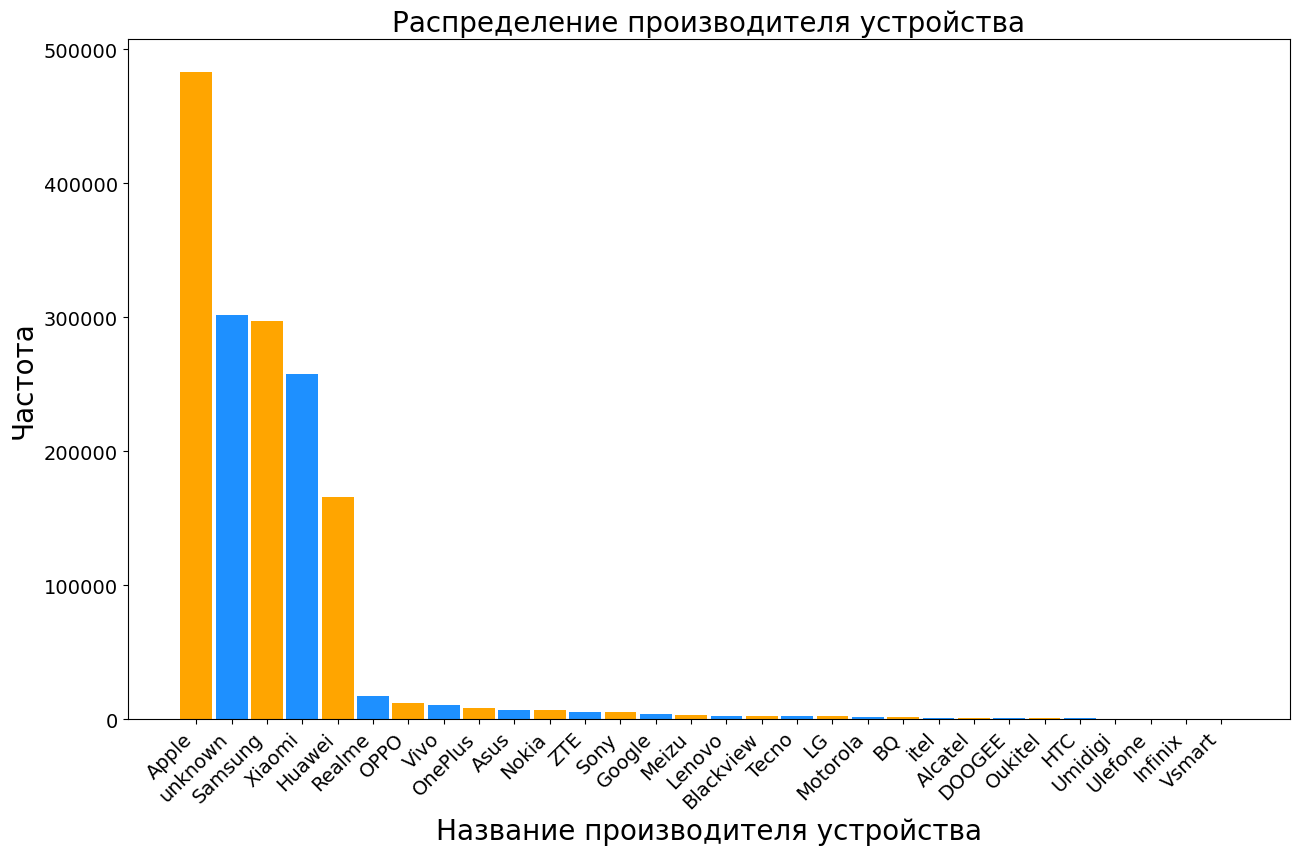

In [58]:
# График распределения марки устройства(30 наиболее часто встречающихся)

distribution_graph(stats_brand, 'device_brand', (15, 10), 'производителя устройства', 30)

In [59]:
# Статистики для столбца с информацией о категории устройства

stats_category = feature_stats(df_full, 'device_category')
stats_category

,device_category,count
1,mobile,1287362
0,desktop,308936
2,tablet,14977


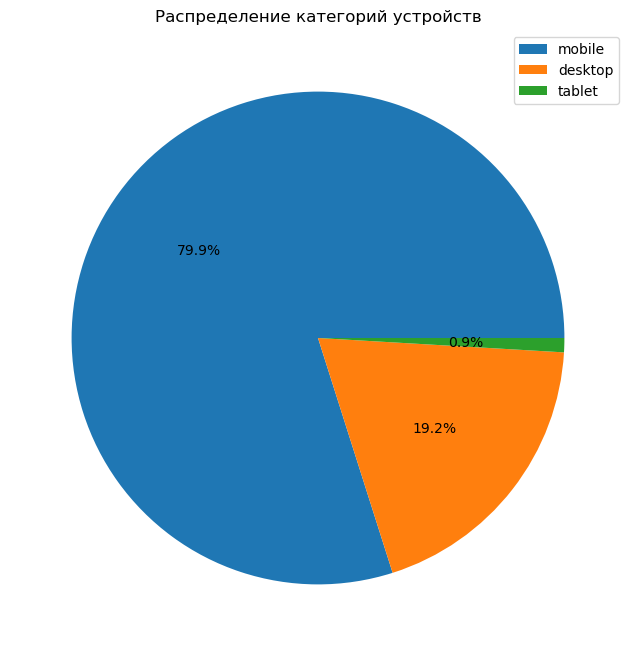

In [60]:
# График распределения категорий устройства

plt.figure(figsize=(12, 8))
plt.pie(stats_category['count'], labels=stats_category['device_category'], labeldistance=None, autopct = '%1.1f%%')
plt.title("Распределение категорий устройств")
plt.legend()
plt.show();

In [61]:
# Статистики для столбца с информацией о браузере устройства

stats_browser = feature_stats(df_full, 'device_browser')
stats_browser.head(5)

,device_browser,count
2,chrome,900102
19,safari,462046
24,yabrowser,106432
1,android,50610
20,samsung,41735


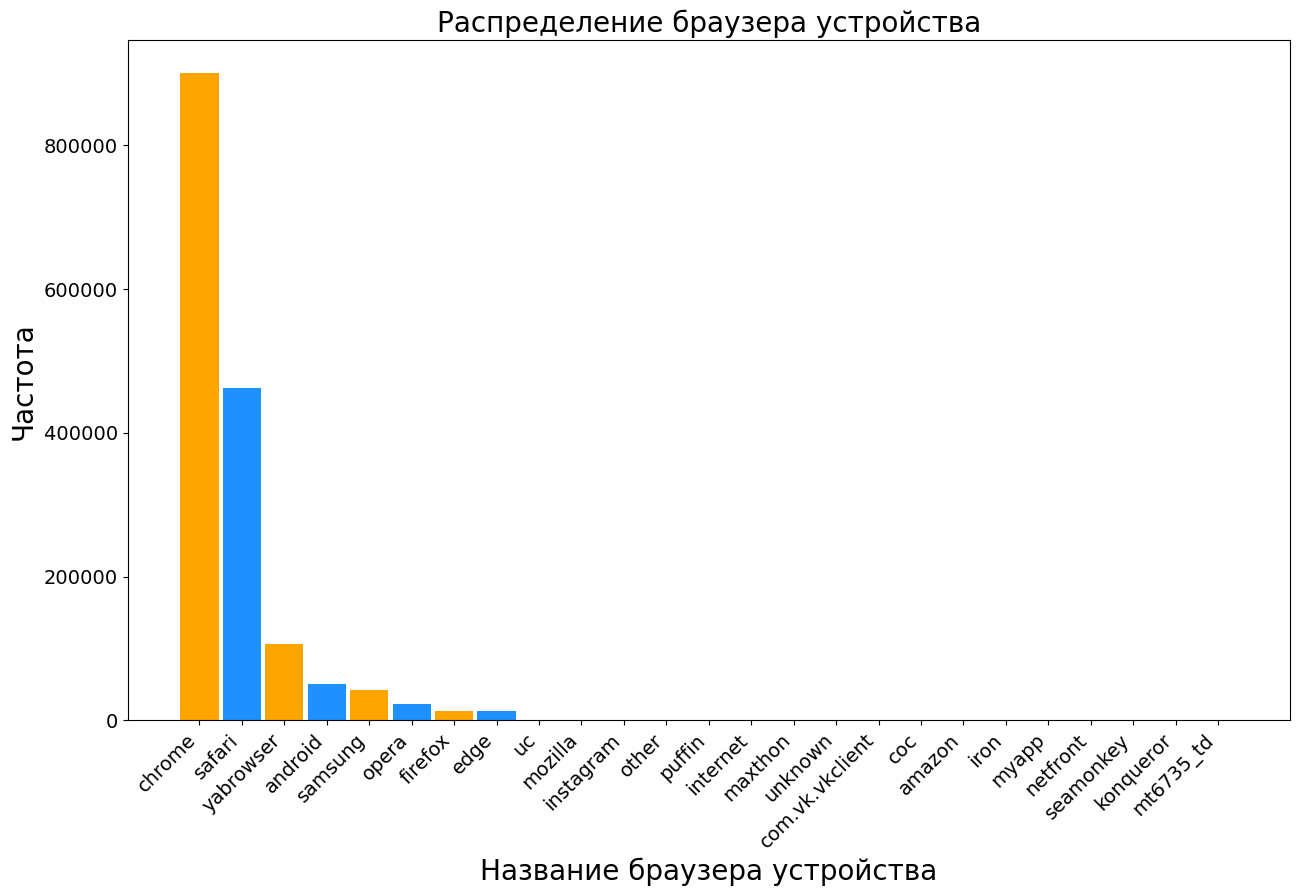

In [62]:
# График распределения категорий устройства

distribution_graph(stats_browser, 'device_browser', (15, 10), 'браузера устройства', 'all')

In [63]:
# Статистики для городов

stats_city = feature_stats(df_full, 'geo_city')
stats_city.head(5)

,geo_city,count
1320,Moscow,684887
1774,Saint Petersburg,252407
2338,unknown,66083
2282,Yekaterinburg,33029
1020,Krasnodar,29709


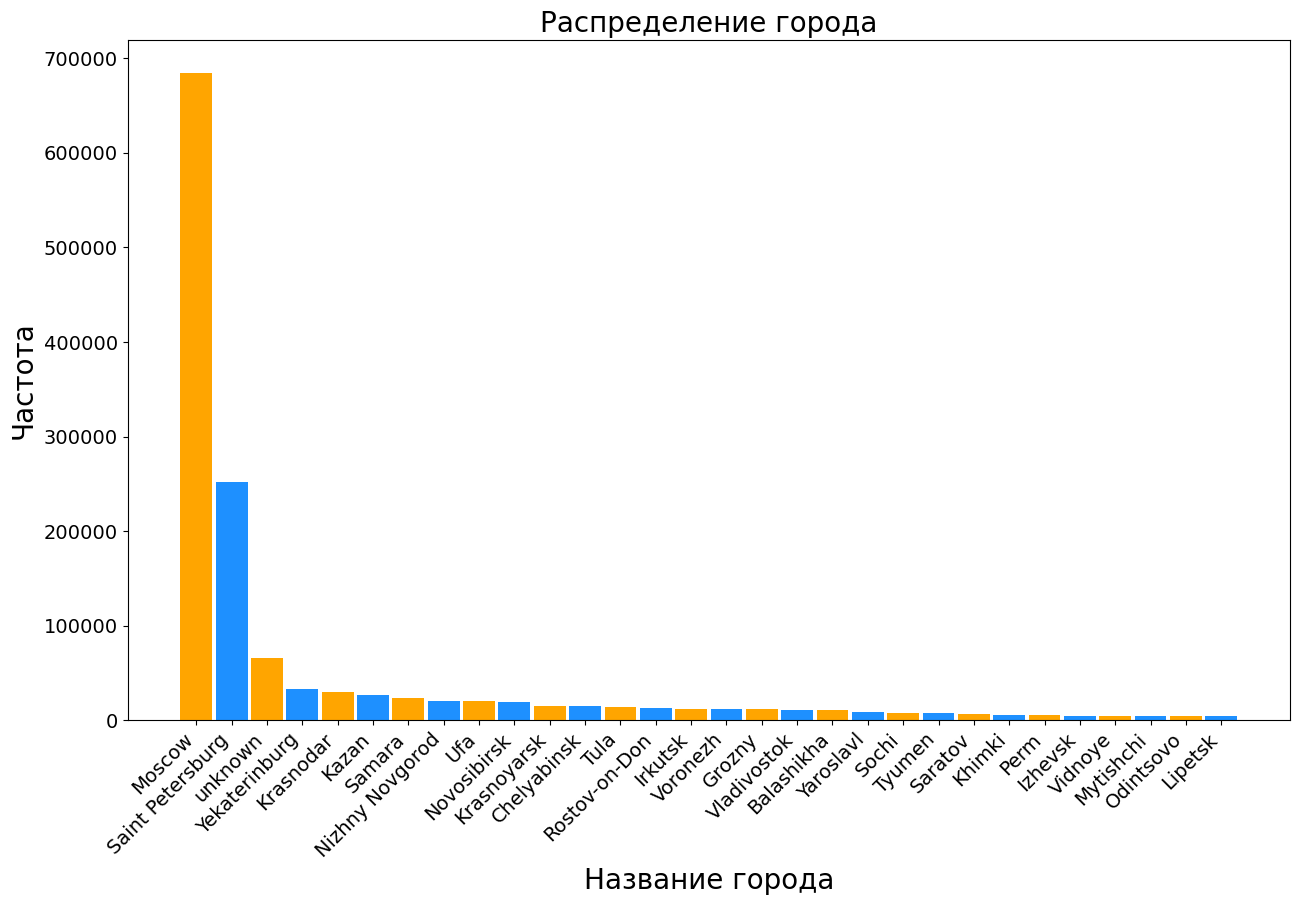

In [64]:
# График распределения городов

distribution_graph(stats_city, 'geo_city', (15, 10), 'города', 30)

In [65]:
# Статистики для стран

stats_country = feature_stats(df_full, 'geo_country')
stats_country.head(5)

,geo_country,count
116,Russia,1563726
147,Ukraine,8201
150,United States,8008
15,Belarus,3148
70,Kazakhstan,2029


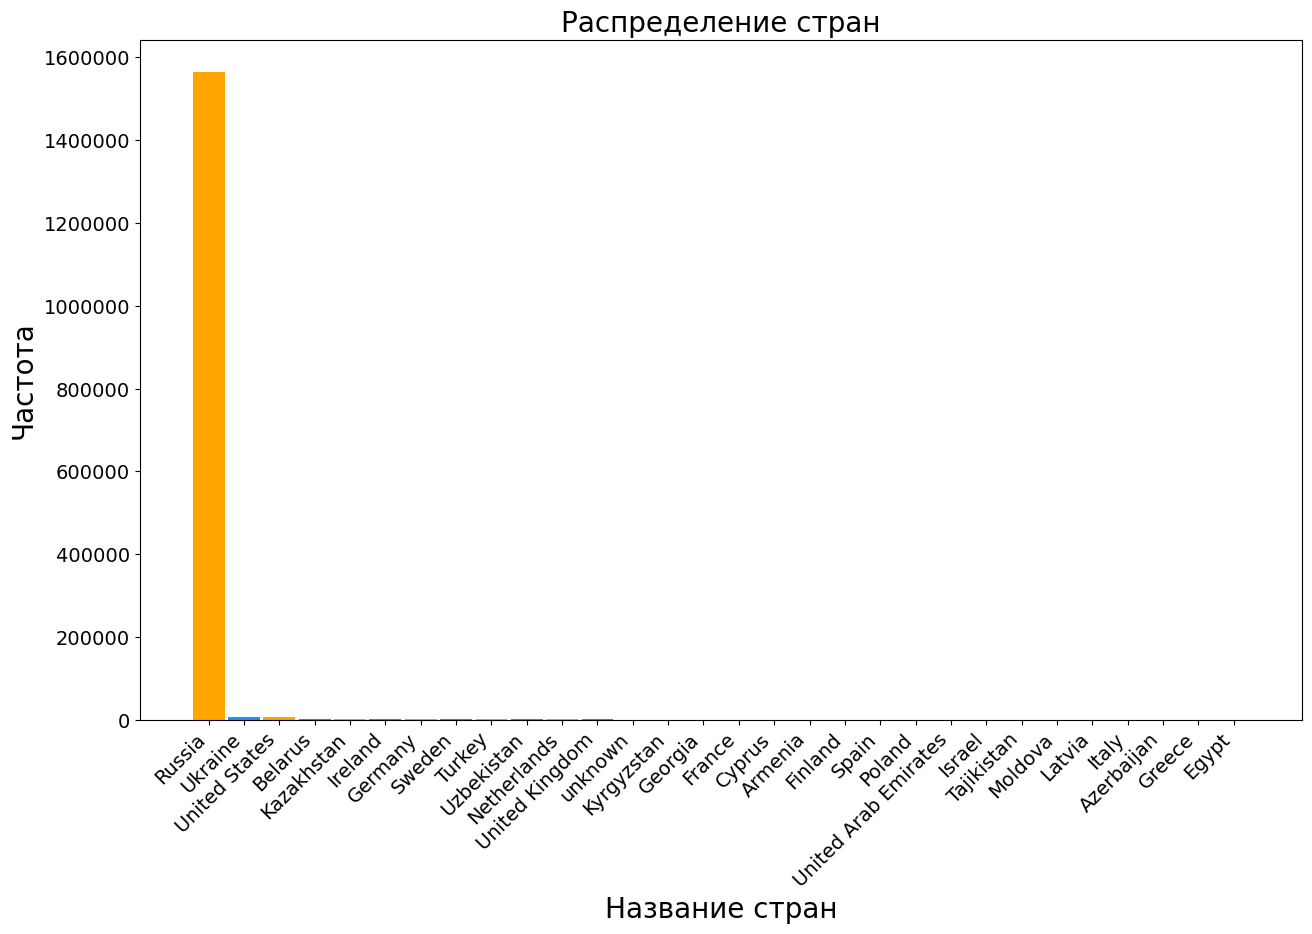

In [66]:
# График распределения стран

distribution_graph(stats_country, 'geo_country', (15, 10), 'стран', 30)

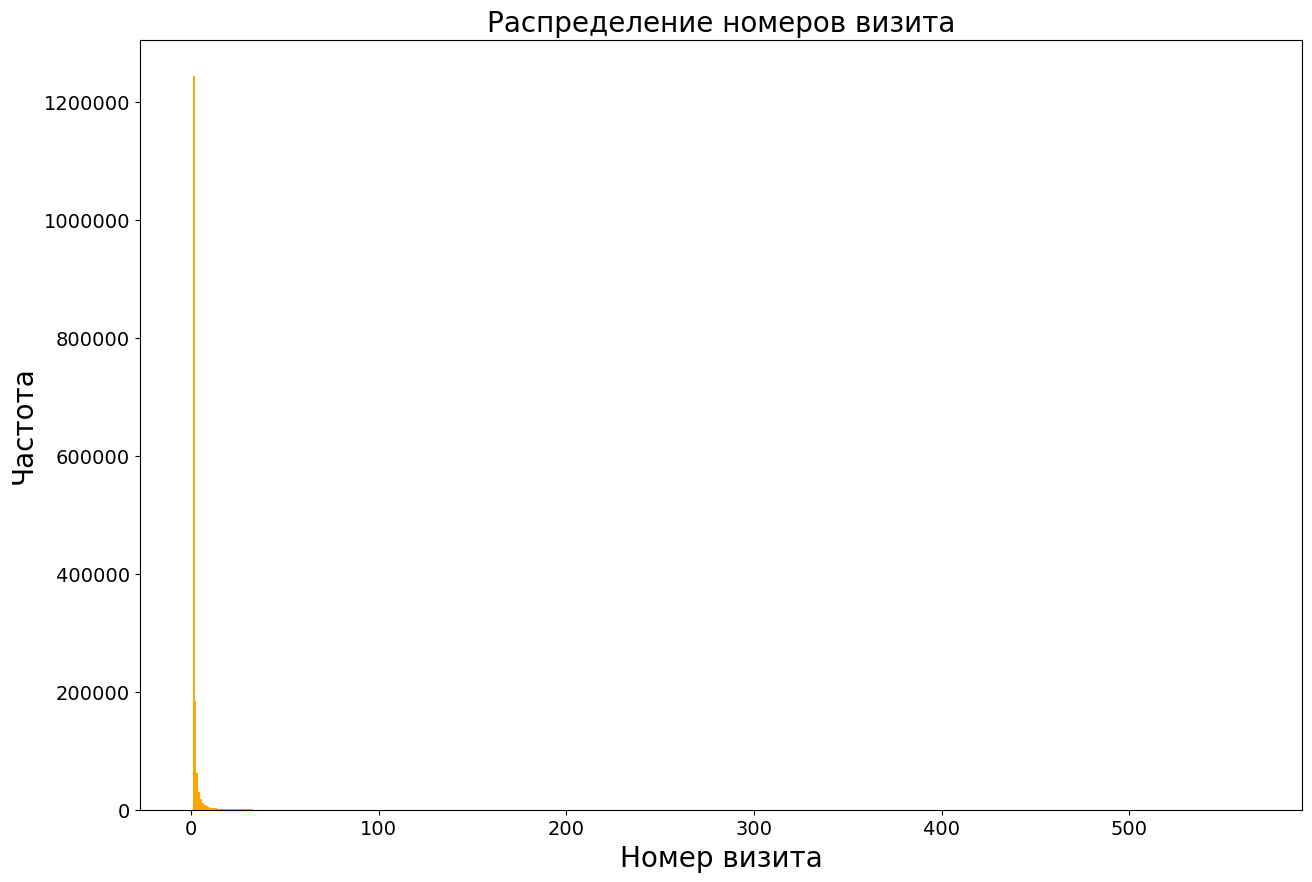

In [67]:
# График распределения порядкового номера визита

fig, ax = plt.subplots(figsize=(15, 10))

ax.hist(df_full['visit_number'].values, bins=564, color=['orange'])
ax.set_xlabel('Номер визита', fontsize = 20)
ax.set_ylabel('Частота', fontsize = 20)
ax.set_title('Распределение номеров визита', fontsize = 20)
ax.tick_params(axis='both', labelsize=14)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'));

## 3. Feature engineering

In [69]:
# Удаление неинформативных столбцов и запись датасета в файл для последующего обучения модели

df_full = df_full.drop(columns=['session_id', 'client_id'])
df_full.to_csv('dags/modules/data/files/sberpodpiska_data_prepared.csv', index=False)

In [70]:
# Преобразование категориальных переменных с помощью TargetEncoder

data = ['utm_source', 'utm_campaign', 'utm_medium', 'utm_keyword', 'utm_adcontent', 'device_browser', 'device_os', 'device_brand', 'device_category', 'geo_country', 'geo_city']
encoder = TargetEncoder()
for elem in data:
     df_full[elem+'_encoding'] = encoder.fit_transform(df_full[elem], df_full['event_action_bin'])

In [71]:
# Удаление первоначальных признаков до преобразований

columns_for_drop = ['utm_source', 'utm_keyword', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'device_browser', 'device_os', 'device_category', 'geo_city', 'device_brand', 'geo_country', 'device_screen_resolution', 'visit_date', 'visit_time']
df_prepared = df_full.drop(columns=columns_for_drop)
df_prepared.head()

,visit_number,event_action_bin,utm_source_encoding,utm_campaign_encoding,utm_medium_encoding,utm_keyword_encoding,utm_adcontent_encoding,device_browser_encoding,device_os_encoding,device_brand_encoding,device_category_encoding,geo_country_encoding,geo_city_encoding
0,1,0,0.028953,0.029096,0.028764,0.033510,0.021796,0.028008,0.027200,0.025756,0.027504,0.028546,0.014151
1,1,0,0.012791,0.010415,0.010962,0.015396,0.012186,0.027555,0.027200,0.031692,0.027504,0.028546,0.030434
2,1,0,0.028953,0.029096,0.028764,0.033510,0.021796,0.028008,0.027200,0.025756,0.027504,0.028546,0.024566
3,1,0,0.023142,0.021807,0.019335,0.012324,0.012517,0.028008,0.027200,0.024136,0.027504,0.028546,0.030434
5,1,0,0.023142,0.044936,0.038176,0.053680,0.034894,0.028110,0.027956,0.028193,0.027504,0.028546,0.024690


## 4. Modelling

In [73]:
# Обозначаем X и y

X = df_prepared.drop(['event_action_bin'], axis=1)
y = df_prepared.event_action_bin

In [74]:
# Разделение данных на обучающую и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [75]:
# Балансировка классов с помощью SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

### Logistic Regression

Logistic Regression - Accuracy: 0.5903248562733898
Logistic Regression - ROC-AUC: 0.6733985284000321


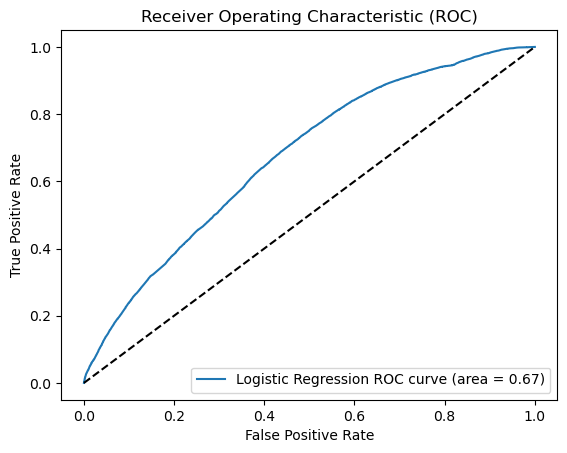

In [78]:
# Обучение модели Logistic Regression
log_reg_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
log_reg_model.fit(X_train_balanced, y_train_balanced)

# Прогнозирование и оценка
y_pred_proba = log_reg_model.predict_proba(X_test)[:, 1]
y_pred = log_reg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Logistic Regression - Accuracy: {accuracy}')
print(f'Logistic Regression - ROC-AUC: {roc_auc}')

# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'Logistic Regression ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### Random Forest

Random Forest - Accuracy: 0.731225549926249
Random Forest - ROC-AUC: 0.6109084875368743


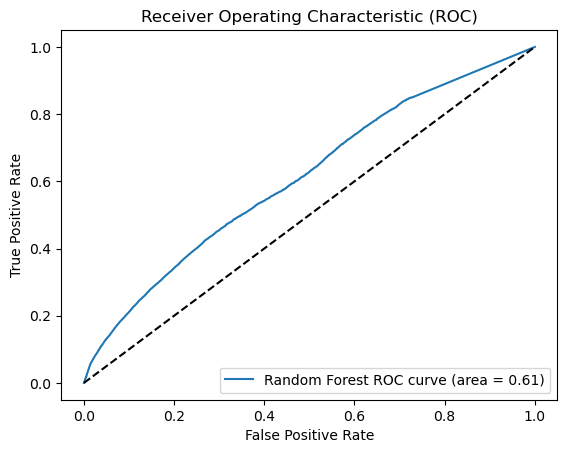

In [80]:
# Обучение модели Random Forest
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

# Прогнозирование и оценка
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Random Forest - Accuracy: {accuracy}')
print(f'Random Forest - ROC-AUC: {roc_auc}')


# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'Random Forest ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### Gradient Boosting

Gradient Boosting - Accuracy: 0.5814478374291193
Gradient Boosting - ROC-AUC: 0.6813694553991219


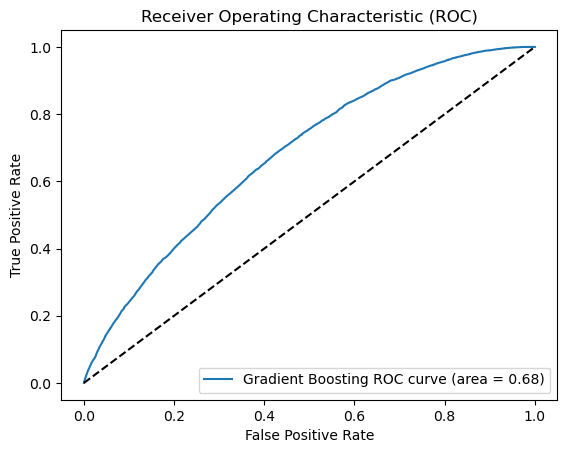

In [82]:
# Обучение модели Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_balanced, y_train_balanced)

# Прогнозирование и оценка
y_pred_proba = gb_model.predict_proba(X_test)[:, 1]
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Gradient Boosting - Accuracy: {accuracy}')
print(f'Gradient Boosting - ROC-AUC: {roc_auc}')



# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'Gradient Boosting ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### HistGradientBoostingClassifier

HistGradientBoostingClassifier - Accuracy: 0.6341803497433712
HistGradientBoostingClassifier - ROC-AUC: 0.6777776187482429


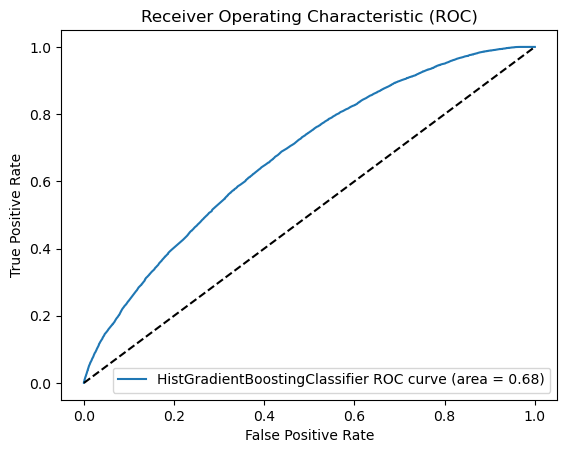

In [84]:
# Обучение модели HistGradientBoostingClassifier
hgbc_model = HistGradientBoostingClassifier(class_weight='balanced', random_state=42)
hgbc_model.fit(X_train_balanced, y_train_balanced)

# Прогнозирование и оценка
y_pred_proba = hgbc_model.predict_proba(X_test)[:, 1]
y_pred = hgbc_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'HistGradientBoostingClassifier - Accuracy: {accuracy}')
print(f'HistGradientBoostingClassifier - ROC-AUC: {roc_auc}')


# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'HistGradientBoostingClassifier ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### XGBoost

XGBoost - Accuracy: 0.6764884160179402
XGBoost - ROC-AUC: 0.6678737840821527


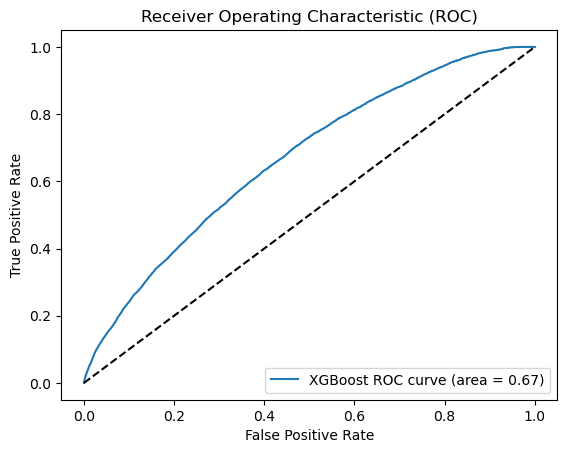

In [86]:
# Определение параметра scale_pos_weight
scale_pos_weight = len(y_train_balanced[y_train_balanced == 0]) / len(y_train_balanced[y_train_balanced == 1])

# Обучение модели XGBoost
xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
xgb_model.fit(X_train_balanced, y_train_balanced)

# Прогнозирование и оценка
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'XGBoost - Accuracy: {accuracy}')
print(f'XGBoost - ROC-AUC: {roc_auc}')


# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'XGBoost ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [87]:
#Кросс валидация для градиентного бустинга (как для модели с лучшим показателем ROC_AUC)

cv_score = cross_val_score(gb_model, X, y, cv=5, scoring='roc_auc')

# Вывод результатов
print(f'Среднее значение оценки кросс-валидации градиентного бустинга: {cv_score.mean()},\nСтандартное отклонение оценки кросс-валидации: {cv_score.std()}')

Среднее значение оценки кросс-валидации градиентного бустинга: 0.6922795448972096,
Стандартное отклонение оценки кросс-валидации: 0.0020957464405609487


## 5. Results

Лучшего всего себя показывает модель Gradient Boosting с значением ROC-AUC: ~0.68

А также модель не переобучена, так как стандартное отклонение оценок кросс-валидации составляет 2.8141e-05, что свидетельствует о том, что оценки на каждом из фолдов очень близки друг к другу. Это может указывать на то, что модель хорошо обобщает данные и не переобучена

В результате выполнения кросс-валидации модели Gradient Boosting (gb_model) на заданных данных (X, y) с использованием 5 фолдов были получены следующие метрики:

- Среднее значение оценки кросс-валидации: **0.9716**. Это означает, что модель демонстрирует высокую среднюю точность на уровне **97.16%**. Данный показатель указывает на то, что модель хорошо подходит для решения данной задачи, предоставляя точные предсказания в большинстве случаев.

- Стандартное отклонение оценки кросс-валидации: **2.8141e-05**. Это очень низкое значение стандартного отклонения, что свидетельствует о высокой стабильности модели. Низкое стандартное отклонение указывает на то, что модель даёт почти идентичные результаты на разных фолдах кросс-валидации. Таким образом, можно утверждать, что модель является надёжной и обладает хорошей обобщающей способностью.

**Вывод:** Модель Gradient Boosting показала высокую среднюю точность и минимальное стандартное отклонение оценок в ходе кросс-валидации. Эти результаты подтверждают, что модель обладает высокой предсказательной способностью и стабильностью на предоставленных данных.

Далее обучим модель на всём датасете


In [90]:
# Обучение модели Gradient Boosting на всём датасете
final_gb_model = GradientBoostingClassifier(random_state=42)
final_gb_model.fit(X, y)

# Прогнозирование на всём датасете
y_pred_proba = final_gb_model.predict_proba(X)[:, 1]
y_pred = final_gb_model.predict(X)

# Оценка точности и ROC-AUC на всём датасете (для информации)
accuracy = accuracy_score(y, y_pred)
roc_auc = roc_auc_score(y, y_pred_proba)

print(f'Final Gradient Boosting - Accuracy: {accuracy:.2f}')
print(f'Final Gradient Boosting - ROC-AUC: {roc_auc:.2f}')

Final Gradient Boosting - Accuracy: 0.97
Final Gradient Boosting - ROC-AUC: 0.70


<b>Обучение и оценка модели Gradient Boosting на всём датасете

Модель Gradient Boosting была обучена на всём доступном датасете. После этого были получены прогнозы на тех же данных, что использовались для обучения, и проведена оценка точности и ROC-AUC.

<b>Процесс:

1. **Обучение модели Gradient Boosting:**
   - Модель `GradientBoostingClassifier` была обучена на всём наборе данных (X, y) с использованием параметра `random_state=42` для обеспечения воспроизводимости результатов.

2. **Прогнозирование:**
   - Были получены вероятности принадлежности классу 1 (`y_pred_proba`) и предсказанные классы (`y_pred`) на всём наборе данных.

3. **Оценка точности и ROC-AUC:**
   - **Точность (Accuracy):**  Модель показала точность **0.97**, что означает, что 97% предсказаний модели совпадают с истинными метками классов. Это указывает на высокую долю правильно классифицированных объектов.
   - **ROC-AUC:** Значение ROC-AUC составило **0.70**, что отражает способность модели различать классы. Значение ROC-AUC ближе к 1 свидетельствует о высокой способности модели правильно классифицировать положительные и отрицательные примеры. В данном случае значение **0.70** указывает на умеренную дискриминативную способность модели.

<b>Выводы:

- **Высокая точность (97%)** модели на всём наборе данных говорит о её хорошем общем уровне производительности.
- **Значение ROC-AUC (0.70)** показывает, что модель имеет приемлемую способность различать классы, но есть потенциал для улучшения дискриминативной способности.

Важно отметить, что поскольку модель была оценена на тех же данных, на которых она обучалась, эти метрики могут быть завышены из-за возможного переобучения. 

Для более объективной оценки производительности модели далее проверим модель на переобучение с помощью кросс-валидации.



In [92]:
# Оценка модели с использованием кросс-валидации
cv_accuracy = cross_val_score(final_gb_model, X, y, cv=5, scoring='accuracy')
cv_roc_auc = cross_val_score(final_gb_model, X, y, cv=5, scoring='roc_auc')

print(f'Cross-validated Accuracy: {cv_accuracy.mean():.2f} ± {cv_accuracy.std():.2f}')
print(f'Cross-validated ROC-AUC: {cv_roc_auc.mean():.2f} ± {cv_roc_auc.std():.2f}')

Cross-validated Accuracy: 0.97 ± 0.00
Cross-validated ROC-AUC: 0.69 ± 0.00


In [93]:
# Сохранение модели
filename = 'dags/modules/data/models/model.pickle'
with open(filename, 'wb') as file:
    pickle.dump(final_gb_model, file)

print(f'Model saved to {filename}')

Model saved to dags/modules/data/models/model.pickle
